In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import requests
import unicodedata
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Project Introduction

Any NBA fan is probably aware that Steph Curry won his first Finals MVP last season (2021-2022). What I wanted to know was not if it should have been his first but why it wasn't his second? I believe and have always believed that Steph was robbed of Finals MVP in 2015. This project set out to prove that fact. The first step was scraping data and compiling it into dataframes.

The first step in this process was to gather the data. Below I have included the code that I used to scrape the data from basketball reference but I haven't ran it here because I don't want to bother the website again. I stored the data in a csv file when I first scraped it so the code is reproduced here as an example only.

In [ ]:
# This was the first dataset I had which was a list of Finals MVPs without stats. 

#Read in the data
df = pd.read_csv("NBA FINALS.csv")
mvps = df[['Unnamed: 0','Finals','Unnamed: 3','Unnamed: 4']]
mvps.columns = ['Year','Champion','Runner-Up', 'Finals MVP']
mvps = mvps[1:]
year_int = lambda x:int(x)
mvps['Year']=mvps.Year.apply(year_int)
mvps=mvps[mvps['Year']>1968] 
mvps = mvps.dropna(how='any').reset_index()

#Here I scraped the stats for all of the Finals MVPs from basketball reference
url = 'https://www.basketball-reference.com/playoffs/2022-nba-finals-celtics-vs-warriors.html'
#gets html from website
page = requests.get(url)
#turns html into a readable file
soup = BeautifulSoup(page.text,'html.parser')
#iterates through all html objects with the tag 'p' and turns them into text
info_list = [row.get_text() for row in soup.find_all('p')]

info_string = info_list[3]
info_list2 = info_string.split('(')
info_string2 = info_list2[1]
info_string3 = unicodedata.normalize('NFC',info_string2)
finals_mvp_stats = [info_string3]
names = [info_list2[0].split(':')[1]]
for i in range(2022-1969):
    next_url = soup.find_all('a', attrs = {'class':'button2 prev'})
    next_url = str(next_url)
    next_url = next_url.split('"')
    next_url = next_url[3]
    next_url = 'https://www.basketball-reference.com' + next_url
    page = requests.get(next_url)
    soup = BeautifulSoup(page.text,'html.parser')
    info_list = [row.get_text() for row in soup.find_all('p')]
    info_string = info_list[3]
    info_list2 = info_string.split('(')
    info_string2 = info_list2[1]
    info_string3 = unicodedata.normalize('NFC',info_string2)
    finals_mvp_stats.append(info_string3)
    names.append(info_list2[0].split(':')[1])
    
#Formatting the scraped data
clean_stats = [unicodedata.normalize('NFKC',i) for i in finals_mvp_stats]
clean_names = [unicodedata.normalize('NFKC',i) for i in names]
clean_stats = [i.split('/') for i in clean_stats]
clean_points = [float(i[0]) for i in clean_stats]
clean_rebs = [float(i[1]) for i in clean_stats]
clean_ast = [float(i[2][:-1]) for i in clean_stats]

#Attaching stats to the dataframe 
mvps['Points Per Game'] = pd.Series(clean_points)
mvps['Rebounds Per Game'] = pd.Series(clean_rebs)
mvps['Assists Per Game'] = pd.Series(clean_ast)
mvps['Name'] = pd.Series(clean_names)

#Exported the MVPs data frame to a CSV file
mvps.to_csv('MVPS.csv')

In [2]:
# This was a decent start but I needed more data.
mvps = pd.read_csv('MVPS.csv')
mvps.head()

,Unnamed: 0,index,Year,Champion,Runner-Up,Finals MVP,Points Per Game,Rebounds Per Game,Assists Per Game,Name
0,0,1,2022,Golden State Warriors,Boston Celtics,S. Curry,31.2,6.0,5.0,Stephen Curry
1,1,2,2021,Milwaukee Bucks,Phoenix Suns,G. Antetokounmpo,35.2,13.2,5.0,Giannis Antetokounmpo
2,2,3,2020,Los Angeles Lakers,Miami Heat,L. James,29.8,11.8,8.5,LeBron James
3,3,4,2019,Toronto Raptors,Golden State Warriors,K. Leonard,28.5,9.8,4.2,Kawhi Leonard
4,4,5,2018,Golden State Warriors,Cleveland Cavaliers,K. Durant,28.8,10.8,7.5,Kevin Durant


# Step One - Scrape and Collate

Here I decided to get the abbreviations for NBA teams using Beatiful Soup to scrape the names from Wikipedia. After scraping the basketball stats I ran into a few problems with team names changing (they move cities, change mascots, etc.) so I ammended the dictionary and later added an exception to the scraping.

In [ ]:
url = 'https://en.wikipedia.org/wiki/Wikipedia:WikiProject_National_Basketball_Association/National_Basketball_Association_team_abbreviations'
#gets html from website
page = requests.get(url)
#turns html into a readable file
soup = BeautifulSoup(page.text,'html.parser')
teams_table = soup.find('table')
abbrevs = pd.read_html(str(teams_table), header = 0)
team_abbrevs = pd.DataFrame(abbrevs[0])
nickname = [list(i.split(' '))[-1] for i in team_abbrevs['Franchise']]
abbrev_dict = {}
for i,n in zip(nickname, team_abbrevs['Abbreviation/Acronym']):
    abbrev_dict[i.lower()] = n
#Fixed a few entrys
abbrev_dict['suns'] = 'PHO'
abbrev_dict['nets'] = 'NJN'
abbrev_dict['supersonics'] = 'SEA'
abbrev_dict['trail'] = 'POR'
abbrev_dict['bullets'] = 'WSB'

Here I scraped the stats of every NBA Finals going back to 1969, the first year that the Finals MVP was introduced.

It took a few trials to get this right but I wanted to get all of the data in one place and then look at it without having to scrape again. I saved everything in a CSV file so I wouldn't have to repeat this process later on.

In [ ]:
url = 'https://www.basketball-reference.com/playoffs/2022-nba-finals-celtics-vs-warriors.html'
page = requests.get(url)
soup = BeautifulSoup(page.text,'html.parser')
finals_table = soup.find(id = 'all_BOS')
new_table = finals_table.contents[4]
finals_list = pd.read_html(str(new_table))
finals_table = soup.find(id = 'all_GSW')
new_table = finals_table.contents[4]
finals_list.append(pd.read_html(str(new_table)))
for i in range(2022-1969):
    next_url = soup.find_all('a', attrs = {'class':'button2 prev'})
    next_url = str(next_url)
    next_url = next_url.split('"')
    next_url = next_url[3]
    teams = str(soup.find_all('a', attrs = {'class':'button2 prev'}))
    teams = teams.split('-')
    team1 = teams[3]
    team2 = teams[-1].split('.')
    team2 = team2[0]
    next_url = 'https://www.basketball-reference.com' + next_url
    page = requests.get(next_url)
    soup = BeautifulSoup(page.text,'html.parser')
    for i in [team1,team2]:
        finals_table = soup.find(id = 'all_' + abbrev_dict[i])
        try:
            new_table = finals_table.contents[4]
        except:
            finals_table = soup.find(id = 'all_BAL')
            new_table = finals_table.contents[4]
            finals_list.append(pd.read_html(str(new_table)))
        else:
            finals_table = soup.find(id = 'all_' + abbrev_dict[i])
            new_table = finals_table.contents[4]
            finals_list.append(pd.read_html(str(new_table)))
 


I used numpy to reshape the data. Eventually I employed try and except clauses and different slicing techniques in order to get the dataframes joined into one large dataframe.

In [ ]:
new_finals_list = []
years = []
for year in range(1969,2023):
    i = [year] * 2
    years += i
years.reverse()
c = []
for i in range(len(finals_list)):
   
    c = finals_list[i]
    #pd.read_html is straight from the devil
    try:
        df = pd.DataFrame(c[0])
    except:
        df = pd.DataFrame(c[0:])
        df = df.droplevel(level = 0,axis = 1)
        df['year'] = years[i]
        new_finals_list.append(df)
    else:
        df = pd.DataFrame(c[0])
        df = df.droplevel(level = 0,axis = 1)
        df['year'] = years[i]
        new_finals_list.append(df)

#Combined all of the data into one big dataframe
ready_for_csv = pd.concat([new_finals_list[0],new_finals_list[1]])
for i in range(2,len(new_finals_list)):
    ready_for_csv = pd.concat([ready_for_csv,new_finals_list[i]])
    
#Exported the data frame to a CSV file
ready_for_csv.to_csv('NBAFinals.csv')

I still needed one last datapoint: winning! The Finals MVP has gone to a player on the winning team every year except for one. I needed to add a binary variable for the Finals MVP to be used as a label for machine learning. I also needed to add a binary variable for players on winning teams to be used as a feature for machine learning.

In [ ]:
#adding a binary for the winner of the finals MVP to use as labels for machine learning later
finals['Finals_MVP'] = [0] * len(finals)
for i,n in zip(mvps.Year,mvps.Name):
    mask = (finals['Year'] == i) & (finals['Player'] == n)
    finals.loc[mask, 'Finals_MVP'] = 1
finals.Finals_MVP.value_counts()

In [ ]:
#Scraping the winning and losing team name from basketball reference
url = 'https://www.basketball-reference.com/playoffs/2022-nba-finals-celtics-vs-warriors.html'
matchups_list = ['/playoffs/2022-nba-finals-celtics-vs-warriors.html']
page = requests.get(url)
soup = BeautifulSoup(page.text,'html.parser')
for i in range(2022-1969):
    next_url = soup.find_all('a', attrs = {'class':'button2 prev'})
    next_url = str(next_url)
    next_url = next_url.split('"')
    next_url = next_url[3]
    matchups_list.append(next_url)
    next_url = 'https://www.basketball-reference.com' + next_url
    page = requests.get(next_url)
    soup = BeautifulSoup(page.text,'html.parser')
    
#Some team names had to be manually fixed because of spelling quirks i.e. trail blazers for 
#trailblazers
year = [int(i.split('/')[2][0:4]) for i in matchups_list]
away_team = [i.split('-')[3] for i in matchups_list]
home_team = [i.split('-')[5].split('.')[0] for i in matchups_list]
away_team[30] = 'trailblazers'
home_team[30] = 'bulls'
away_team[32] = 'trailblazers'
home_team[32] = 'pistons'
away_team[45] = 'trailblazers'
home_team[45] = '76ers'

#scraping the champion's name
url = 'https://www.basketball-reference.com/playoffs/'
page = requests.get(url)
soup = BeautifulSoup(page.text,'html.parser')
playoffs_table = soup.find(id = 'all_champions_index')
playoffs_table = pd.read_html(str(playoffs_table), header = 0)

#creating a dataframe of team names and champion names
df = pd.DataFrame(playoffs_table[0])
df = df.drop([0])
df = df.rename(columns = {'Unnamed: 0':'Year','Unnamed: 1':'Lg', 'Finals':'Champion'})
df = df.dropna(subset = 'Year')
df['Year'] = df['Year'].astype('int')
champion = df[(df['Year'] > 1968) & (df['Lg'] == 'NBA')]['Champion']
champion = np.array(champion)

#fixing column names
winners_losers_dict = {'Year':year, 'Away':away_team, 'Home':home_team}
teams_df = pd.DataFrame(winners_losers_dict)
teams_df['Champion'] = champion

#Exported the data frame to a CSV file
teams_df.to_csv('Champions.csv')


In [10]:
#loading in the Champions dataset to attach columns to the big dataset
champs = pd.read_csv('Champions.csv')

#loading in the big dataset
finals = pd.read_csv('NBAFinals.csv')
#Split into teams to get length of each team
team_length = np.split(finals,np.where(finals.Rk == 1.0)[0])
team_length.pop(0)
#Create a list of teams alternating between home and away
teams = [None]*len(team_length)
teams[::2] = champs['Away']
teams[1::2] = champs['Home']
#Create a list the length of the dataframe for a new column
all_team_names = sum([[team.title()] * len(length) for team, length in zip(teams,team_length)],[])
finals['Team'] = all_team_names

#Create a binary variable for winning
finals['Winning Team'] = [0] * len(finals)
for i,n in zip(champs.Year,champs.Champion):
    mask = (finals['Year'] == i) & (finals['Team'] == n.split()[-1])
    finals.loc[mask, 'Winning Team'] = 1
#check
print(finals['Winning Team'].value_counts())

#save to CSV
finals.to_csv('NBAFinals.csv')


0    663
1    597
Name: Winning Team, dtype: int64


Additional cleaning that happened to the dataset that is not captured above includes renaming columns and eliminating rows of "team totals."

# Step Two - Clean the Data and Preliminary Analysis

The CSV file will still have a few unwanted rows. However, I ignored most null values as they are almost certainly explainable (i.e. lack of 3pt statistics prior to 1979 is due to the fact that the 3pt line was introduced in 1979). We left them in and dealt with them on a case by case basis. 

A good example is below actually: in row 5 you can see that Robert Williams, a key player for the Celtics in the 2022 NBA Finals has a NaN value for 3P%. Dropping that row would be nonsensical. 0 will serve as a fine replacement for that value.

In [3]:
finals = pd.read_csv('NBAFinals.csv')
print(finals['3P%'].head(10))

0    0.340
1    0.455
2    0.412
3    0.625
4    0.400
5      NaN
6    0.300
7    0.214
8    0.000
9    1.000
Name: 3P%, dtype: float64


In [28]:
#create a table of the leading scorer, their PPG, the finals MVP, their PPG, and the difference

leading_scorer_ppg = finals.groupby(['Year']).PPG.max()
leading_scorer = []

for i,n in zip(leading_scorer_ppg.index,leading_scorer_ppg):
    mask = (finals['Year'] == i) & (finals['PPG'] == n)
    leading_scorer.append(finals.loc[mask,'Player'].values)
    
leaders = pd.DataFrame(leading_scorer, columns = ['Leading Scorer'], 
                       index = leading_scorer_ppg.index)
leaders['PPG'] = list(leading_scorer_ppg)
mvps_list = list(mvps['Name'])
mvps_list.reverse()
clean_mvps_list = [i.strip() for i in mvps_list]
mvps_PPG = list(mvps['Points Per Game'])
mvps_PPG.reverse()
leaders['Finals MVP'] = clean_mvps_list
leaders['Finals MVP PPG'] = mvps_PPG
leaders['PPG Difference'] = leaders['PPG'] - leaders['Finals MVP PPG']
leaders.head(20)

,Leading Scorer,PPG,Finals MVP,Finals MVP PPG,PPG Difference
Year,,,,,
1969,Jerry West,37.9,Jerry West,37.9,0.0
1970,Jerry West,31.3,Willis Reed,23.0,8.3
1971,Kareem Abdul-Jabbar,27.0,Kareem Abdul-Jabbar,27.0,0.0
1972,Gail Goodrich,25.6,Wilt Chamberlain,19.4,6.2
1973,Gail Goodrich,21.8,Willis Reed,16.4,5.4
1974,Kareem Abdul-Jabbar,32.6,John Havlicek,26.4,6.2
1975,Rick Barry,29.5,Rick Barry,29.5,0.0
1976,Alvan Adams,23.0,Jo Jo White,21.7,1.3
1977,Julius Erving,30.3,Bill Walton,18.5,11.8


From below we can see that 32/54 Finals MVPs have been the leading scorer in the series. We will also want to check for leading scorers on teams. We can do that by affixing rank to the above table. Before we do that, however, we look at the difference between leading scorers and Finals MVPs. As you can tell from the Violin plot, most of the data is clustered in 3-4 bunches. Who is that stray point?

In [29]:
sum(leaders['Leading Scorer'] == leaders['Finals MVP'])

32

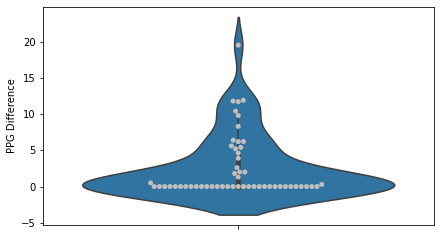

In [32]:
plt.figure(figsize = (7,4))
ax = sns.violinplot(data = leaders, y ='PPG Difference')
ax = sns.swarmplot(data = leaders, y ='PPG Difference', color = '.75')

In [33]:
leaders[leaders['PPG Difference'] > 10]

,Leading Scorer,PPG,Finals MVP,Finals MVP PPG,PPG Difference
Year,,,,,
1977,Julius Erving,30.3,Bill Walton,18.5,11.8
1978,Elvin Hayes,20.7,Wes Unseld,9.0,11.7
1980,Kareem Abdul-Jabbar,33.4,Magic Johnson,21.5,11.9
2014,LeBron James,28.2,Kawhi Leonard,17.8,10.4
2015,LeBron James,35.8,Andre Iguodala,16.3,19.5


The stray point is Andre Iguodala! In 2015! The very year we wanted to question! What about the other people on this list?

In the first instance the players are on opposing teams. No player, other than Jerry West, has won Finals MVP in a losing effort so I'll be looking at teammates in these instances to see if there was a better candidate.

Bill Walton scored 1.2 PPG less than Maurice Lucas but he outrebounded him by nearly double. This is just a cursory look. We'll dig in more in a minute.

In [34]:
finals[finals['Year'] == 1977][0:2]

,Unnamed: 0.1,Unnamed: 0,Index,Rk,Player,Age,G,MP,FG,FGA,...,MPG,PPG,RPG,APG,SPG,BPG,Year,Finals_MVP,Team,Winning Team
1064,1064,1154,0,1.0,Maurice Lucas,24.0,6,213,43,98,...,35.5,19.7,10.7,3.5,1.8,0.7,1977,0,Trailblazers,0
1065,1065,1155,1,2.0,Bill Walton,24.0,6,226,48,88,...,37.7,18.5,19.0,5.2,1.0,3.7,1977,1,Trailblazers,0


This is a pretty strange one. Wes Unseld was the 7th leading scorer on his team!

In [35]:
finals[finals['Year'] == 1978][0:7]

,Unnamed: 0.1,Unnamed: 0,Index,Rk,Player,Age,G,MP,FG,FGA,...,MPG,PPG,RPG,APG,SPG,BPG,Year,Finals_MVP,Team,Winning Team
1042,1042,1130,0,1.0,Elvin Hayes,32.0,7,276,61,127,...,39.4,20.7,11.9,1.4,1.6,2.0,1978,0,Bullets,1
1043,1043,1131,1,2.0,Bob Dandridge,30.0,7,284,59,131,...,40.6,20.4,7.0,4.1,1.0,1.0,1978,0,Bullets,1
1044,1044,1132,2,3.0,Kevin Grevey,24.0,7,173,35,94,...,24.7,13.0,3.1,1.6,0.1,0.4,1978,0,Bullets,1
1045,1045,1133,3,4.0,Tom Henderson,26.0,7,250,31,72,...,35.7,12.9,2.7,5.7,2.0,0.4,1978,0,Bullets,1
1046,1046,1134,4,5.0,Charles Johnson,28.0,7,156,34,86,...,22.3,10.7,2.6,2.6,1.6,0.0,1978,0,Bullets,1
1047,1047,1135,5,6.0,Mitch Kupchak,23.0,7,138,31,59,...,19.7,10.7,4.6,1.0,0.0,0.3,1978,0,Bullets,1
1048,1048,1136,6,7.0,Wes Unseld,31.0,7,270,26,50,...,38.6,9.0,11.7,3.9,0.6,0.1,1978,1,Bullets,1


Fans of basketball will recognize this as the game that announced Magic Johnson as a force. He suited up at center in Game 6 because Kareem was injured.

In [36]:
finals[finals['Year'] == 1980][11:13]

,Unnamed: 0.1,Unnamed: 0,Index,Rk,Player,Age,G,MP,FG,FGA,...,MPG,PPG,RPG,APG,SPG,BPG,Year,Finals_MVP,Team,Winning Team
1012,1012,1097,0,1.0,Kareem Abdul-Jabbar,32.0,5,203,73,133,...,40.6,33.4,13.6,3.2,0.6,4.6,1980,0,Lakers,1
1013,1013,1098,1,2.0,Magic Johnson,20.0,6,256,47,82,...,42.7,21.5,11.2,8.7,2.7,0.3,1980,1,Lakers,1


Again, the players were on opposing teams. Call it the Jerry West Principle. Anyway, Kawhi is very close to Tony Parker here.

In [37]:
finals[finals['Year'] == 2014][14:16]

,Unnamed: 0.1,Unnamed: 0,Index,Rk,Player,Age,G,MP,FG,FGA,...,MPG,PPG,RPG,APG,SPG,BPG,Year,Finals_MVP,Team,Winning Team
224,224,241,0,1.0,Tony Parker,31.0,5,176,35,73,...,35.2,18.0,0.4,4.6,0.8,0.0,2014,0,Spurs,1
225,225,242,1,2.0,Kawhi Leonard,22.0,5,167,30,49,...,33.4,17.8,6.4,2.0,1.6,1.2,2014,1,Spurs,1


Here's why we asked the question. Taking into account the Jerry West Principle, only the 1978 and 1980 Finals have such a large discrepancy.

In [38]:
finals[finals['Year'] == 2015][11:16]

,Unnamed: 0.1,Unnamed: 0,Index,Rk,Player,Age,G,MP,FG,FGA,...,MPG,PPG,RPG,APG,SPG,BPG,Year,Finals_MVP,Team,Winning Team
197,197,212,0,1.0,Stephen Curry,26.0,6,255,54,122,...,42.5,26.0,5.2,6.3,1.8,0.2,2015,0,Warriors,1
198,198,213,1,2.0,Andre Iguodala,31.0,6,222,37,71,...,37.0,16.3,5.8,4.0,1.3,0.3,2015,1,Warriors,1
199,199,214,2,3.0,Klay Thompson,24.0,6,227,36,88,...,37.8,15.8,4.3,1.7,0.5,1.0,2015,0,Warriors,1
200,200,215,3,4.0,Draymond Green,24.0,6,222,24,63,...,37.0,13.0,8.3,5.0,2.2,1.2,2015,0,Warriors,1
201,201,216,4,5.0,Harrison Barnes,22.0,6,198,19,51,...,33.0,8.8,5.8,0.8,0.8,0.5,2015,0,Warriors,1


Okay so for 1977 and 2014, we see that the Finals MVP rank was 2 and their PPG was within 2 points of the leading scorer on their team (remember, losers don't win Finals MVP!).

Although 1980 has a Finals MVP with a rank of 2, the PPG discrepancy is still large.

1978 is crazy. 2015 is interesting.

Let's go ahead and affix rank to the leaders table just to see if there are any other instances like 1978 out there. It's unlikely.

In [39]:
mvp_ranks = finals[finals['Finals_MVP'] == 1]['Rk']
mvp_ranks = mvp_ranks.iloc[::-1].values
leaders['Rank'] = mvp_ranks
leaders.Rank.value_counts()

1.0    43
2.0     7
3.0     2
7.0     1
5.0     1
Name: Rank, dtype: int64

So our suspicion is looking good so far. If you lead the series (and win) or your team in scoring you have a good chance of being Finals MVP. Let's look at all instances of someone not leading their team in scoring.

In [40]:
import numpy as np

team_leader = []
team_leader_ppg = []
not_leaders = leaders[leaders['Rank'] > 1]
not_leaders.rename(columns = {'PPG Difference':'Difference from Leading Scorer'},
                   inplace = True)

for i,n,x in zip(not_leaders.index,not_leaders['Finals MVP'],not_leaders['Rank']):
    mask = (finals['Year'] == i) &  (finals['Player'] == n )
    location = finals.loc[mask,'Player'].index.values - (x-1)
    team_leader.append(finals.loc[location,'Player'].values)
    team_leader_ppg.append(finals.loc[location,'PPG'].values)
not_leaders['Team Leader in PPG'] = np.array(team_leader)
fixedppg = np.array(team_leader_ppg)
fixed = fixedppg.reshape(1,11)
not_leaders['Difference from Teammate'] = (fixed[0] - 
          np.array(not_leaders['Finals MVP PPG']))
not_leaders

/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_47550/1045640793.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_leaders.rename(columns = {'PPG Difference':'Difference from Leading Scorer'},
/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_47550/1045640793.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_leaders['Team Leader in PPG'] = np.array(team_leader)
/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_47550/1045640793.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,Leading Scorer,PPG,Finals MVP,Finals MVP PPG,Difference from Leading Scorer,Rank,Team Leader in PPG,Difference from Teammate
Year,,,,,,,,
1972,Gail Goodrich,25.6,Wilt Chamberlain,19.4,6.2,3.0,Gail Goodrich,6.2
1973,Gail Goodrich,21.8,Willis Reed,16.4,5.4,3.0,Bill Bradley,2.2
1977,Julius Erving,30.3,Bill Walton,18.5,11.8,2.0,Maurice Lucas,1.2
1978,Elvin Hayes,20.7,Wes Unseld,9.0,11.7,7.0,Elvin Hayes,11.7
1979,Gus Williams,29.0,Dennis Johnson,22.6,6.4,2.0,Gus Williams,6.4
1980,Kareem Abdul-Jabbar,33.4,Magic Johnson,21.5,11.9,2.0,Kareem Abdul-Jabbar,11.9
1982,Andrew Toney,26.0,Magic Johnson,16.2,9.8,5.0,Jamaal Wilkes,3.5
1986,Kevin McHale,25.8,Larry Bird,24.0,1.8,2.0,Kevin McHale,1.8
2004,Shaquille O'Neal,26.6,Chauncey Billups,21.0,5.6,2.0,Richard Hamilton,0.4


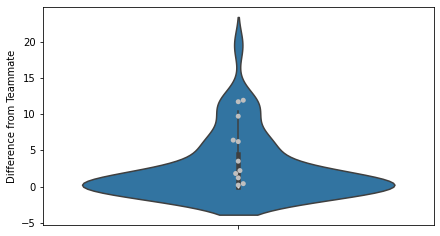

In [41]:
plt.figure(figsize = (7,4))
ax = sns.violinplot(data = leaders, y ='PPG Difference')
ax = sns.swarmplot(data = not_leaders, y ='Difference from Teammate', color = '.75')

In this scenario Steph's PPG discrepancy is not an outlier! It's near the max value, but not an outlier

Of course, this is just points per game. It doesn't take into account all of the other things that Steph does or did. That argument, however, is more for a conversation of who SHOULD win the MVP. We could argue that by looking at other traditional stats, advanced stats, etc. What we want to know is who WOULD have won MVP in 2015 given the history of voting for the award? If we train a model on this data and teach it to try to choose the player who will win, it will be basing it off of who has won in the past. The winners have been chosen subjectively by media memebers.

# Step Three - Building a Model

To see the development of the model you can look at the other jupyter notebook file. What follows below is the most streamlined version of the model with the highest precision, accuracy and recall in predicting MVPs. 

As a slight review: in order to include the most data possible I excluded percentage stats and other stats that weren't recorded for the entire history of the award. The inclusion of those statistics didn't improve precision. After trial and error we were left with five features. We check their correlation below for preprocessing. 

In [71]:
features = finals[['G','MPG' ,'PPG' ,'RPG', 'APG','Winning Team']]
labels = finals['Finals_MVP']
print(len(features),len(labels))

1260 1260


In [72]:
features.corr()

,G,MPG,PPG,RPG,APG,Winning Team
G,1.000000,0.579164,0.437497,0.406981,0.364276,0.023711
MPG,0.579164,1.000000,0.866757,0.744912,0.720701,-0.017376
PPG,0.437497,0.866757,1.000000,0.657823,0.709171,0.007850
RPG,0.406981,0.744912,0.657823,1.000000,0.435530,0.004408
APG,0.364276,0.720701,0.709171,0.435530,1.000000,0.007543
Winning Team,0.023711,-0.017376,0.007850,0.004408,0.007543,1.000000


There was one feature that required some investigation. The correlation between MPG and PPG is very high (0.87). Removing it allowed the model to reach higher scores of precision and accuracy.

In [73]:
features = finals[['G', 'PPG','RPG', 'APG','Winning Team']]

In [74]:
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
scaled_data = scale(features, axis = 0)
print(scaled_data[0])
#training the model
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, 
                        labels, test_size = 0.2, random_state = 4)
#evaluating the model
classifier = KNeighborsClassifier(n_neighbors = 11)
classifier.fit(train_data, train_labels)
classifier.score(test_data, test_labels)

[ 0.70872854  1.77818739  0.93772355  0.76619479 -0.94892175]


0.9801587301587301

Using a few different metrics we looked for the best amount of clusters. 3 was a starting point. Then 11. 

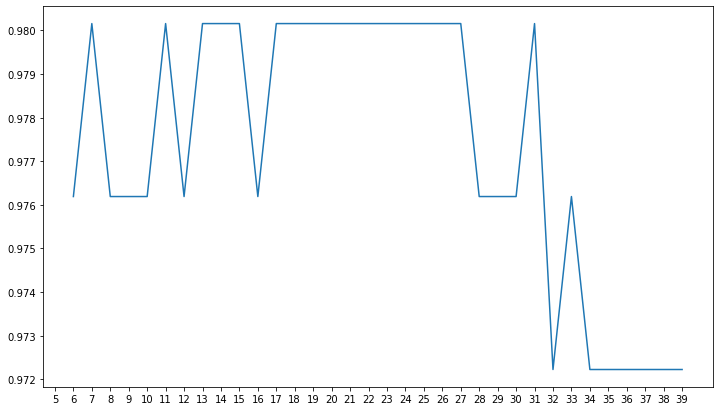

In [79]:
from sklearn.metrics import precision_score,confusion_matrix
plt.figure(figsize = (12,7))
scores = []
for k in range (6,40):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
plt.plot(range(6,40), scores) 
plt.xticks(ticks = range(5,40),labels = range(5,40))
plt.show()

Earlier versions of the model produced a 97% accuracy rate. From above we can see that the model gets up to 98.02%

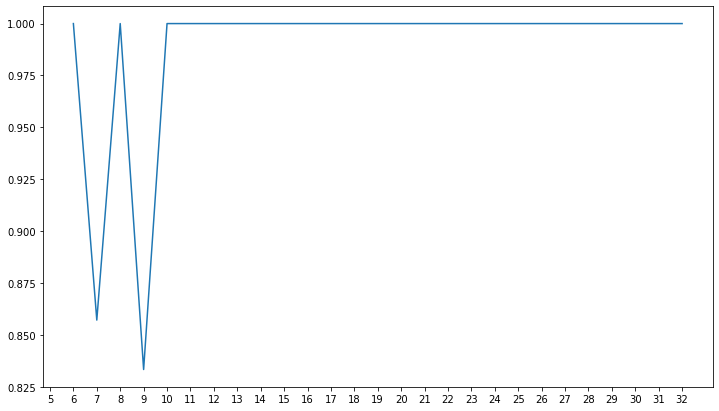

In [83]:
from sklearn.metrics import precision_score
precision_scores = []
for k in range (6,33):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    predictions = classifier.predict(test_data)
    precision_scores.append(precision_score(test_labels,predictions))
plt.figure(figsize = (12,7))
plt.plot(range(6,33), precision_scores)
plt.xticks(ticks = range(5,33),labels = range(5,33))
plt.show()
#confusion_matrix(test_labels,predictions)

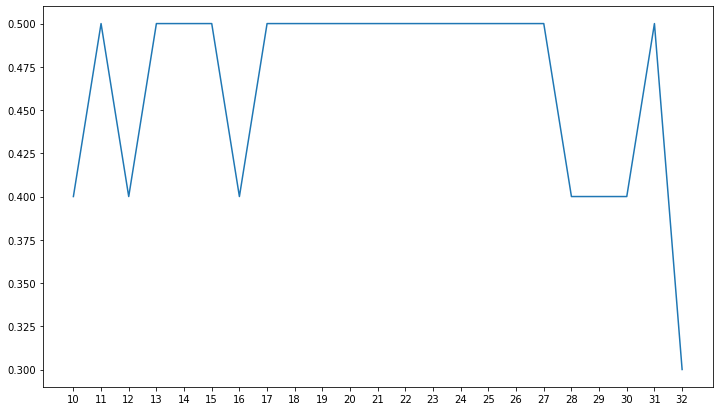

In [85]:
from sklearn.metrics import recall_score
recall_scores = []
for k in range (10,33):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_data, train_labels)
    predictions = classifier.predict(test_data)
    recall_scores.append(recall_score(test_labels,predictions))
plt.figure(figsize = (12,7))
plt.plot(range(10,33), recall_scores)
plt.xticks(ticks = range(10,33),labels = range(10,33))
plt.show()

In [101]:
from sklearn.metrics import confusion_matrix
classifier = KNeighborsClassifier(n_neighbors = 11)
classifier.fit(train_data, train_labels)
print(classifier.score(test_data, test_labels))
predictions = classifier.predict(test_data)
confusion_matrix(test_labels,predictions)

0.9801587301587301


array([[242,   0],
       [  5,   5]])

The precision was improved by 10 plus percentage points from earlier models that did not include winning as a feature. The confusion matrix shows 247/252 predicted correctly. 

Should we be surprised that the model has 7 and 11 clusters? In terms of basketball it makes reasonable sense. 7 players is usually the size of the rotation in the playoffs. 11 is very near the team size of 12-15 players. 

Taking into account the precision, accuracy and recall we decided to go with 11 clusters. We then ran the 2015 Finals in the model to see who you would reasonably expect to win the Finals MVP. Rather than looking at labels which would be either 1 or 0, we chose to look at probabilities. A different version of this model involved logistic regression but the k neighbors model proved to be more effective.

In [102]:
finals2015 = finals[['G', 'PPG', 'RPG', 'APG','Winning Team','Year']]
features2015 = finals2015[finals2015['Year'] == 2015]
features2015.fillna(0, inplace = True)
data2015 = features2015[['G', 'PPG', 'RPG', 'APG','Winning Team']]
scaled_data_2015 = scale(data2015, axis = 0)
for i in zip(finals[finals['Year'] == 2015]['Player'],classifier.predict_proba(scaled_data_2015)):
    print(i)

('LeBron James', array([1., 0.]))
('Timofey Mozgov', array([1., 0.]))
('J.R. Smith', array([1., 0.]))
('Tristan Thompson', array([1., 0.]))
('Matthew Dellavedova', array([1., 0.]))
('Iman Shumpert', array([1., 0.]))
('Kyrie Irving', array([1., 0.]))
('James Jones', array([1., 0.]))
('Mike Miller', array([1., 0.]))
('Kendrick Perkins', array([1., 0.]))
('Joe Harris', array([1., 0.]))
('Stephen Curry', array([0.54545455, 0.45454545]))
('Andre Iguodala', array([0.90909091, 0.09090909]))
('Klay Thompson', array([1., 0.]))
('Draymond Green', array([0.90909091, 0.09090909]))
('Harrison Barnes', array([1., 0.]))
('Leandro Barbosa', array([1., 0.]))
('Shaun Livingston', array([1., 0.]))
('Festus Ezeli', array([1., 0.]))
('David Lee', array([1., 0.]))
('Andrew Bogut', array([1., 0.]))
('Marreese Speights', array([1., 0.]))
('Justin Holiday', array([1., 0.]))
('James Michael McAdoo', array([1., 0.]))


/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_47550/948874261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features2015.fillna(0, inplace = True)


This shows that Steph Curry would have a 45% chance of winning the award. Lebron, who some people thought should win it despite losing, would have basically no chance to win the award. Andre Iguodala, who won the award, would have a 9% chance as would Draymond.

The fact that Steph is under 50% is interesting. He still was the most likely to win in the series but he isn't an overwhelming favorite to win it. Just like real life.

# Step Four - Extension

The Finals MVP is named after NBA legend Bill Russell who won 11 NBA championships. I would like to put him into the model and see his chances of winning.

I scraped every year of Bill Russell's career. As above I will not rerun the code here. It is displayed and then loaded in from csv.

In [ ]:
russell_finals = []
url = 'https://www.basketball-reference.com/playoffs/1969-nba-finals-celtics-vs-lakers.html'
page = requests.get(url)
soup = BeautifulSoup(page.text,'html.parser')
finals_table = soup.find(id = 'all_BOS')
new_table = finals_table.contents[4]
russell_finals.append(pd.read_html(str(new_table)))
finals_table = soup.find(id = 'all_LAL')
new_table = finals_table.contents[4]
russell_finals.append(pd.read_html(str(new_table)))
for i in range(1969-1962):
    next_url = soup.find_all('a', attrs = {'class':'button2 prev'})
    next_url = str(next_url)
    next_url = next_url.split('"')
    next_url = next_url[3]
    teams = str(soup.find_all('a', attrs = {'class':'button2 prev'}))
    teams = teams.split('-')
    team1 = teams[3]
    team2 = teams[-1].split('.')
    team2 = team2[0]
    next_url = 'https://www.basketball-reference.com' + next_url
    page = requests.get(next_url)
    soup = BeautifulSoup(page.text,'html.parser')
    for i in [team1,team2]:
        finals_table = soup.find(id = 'all_' + abbrev_dict[i])
        try:
            new_table = finals_table.contents[4]
        except:
            finals_table = soup.find(id = 'all_SFW')
            new_table = finals_table.contents[4]
            russell_finals.append(pd.read_html(str(new_table)))
        else:
            finals_table = soup.find(id = 'all_' + abbrev_dict[i])
            new_table = finals_table.contents[4]
            russell_finals.append(pd.read_html(str(new_table)))

abbrev_dict['hawks'] = 'STL'
abbrev_dict['lakers'] = 'MNL'
for i in range(1961-1956):
    next_url = soup.find_all('a', attrs = {'class':'button2 prev'})
    next_url = str(next_url)
    next_url = next_url.split('"')
    next_url = next_url[3]
    teams = str(soup.find_all('a', attrs = {'class':'button2 prev'}))
    teams = teams.split('-')
    team1 = teams[3]
    team2 = teams[-1].split('.')
    team2 = team2[0]
    next_url = 'https://www.basketball-reference.com' + next_url
    page = requests.get(next_url)
    soup = BeautifulSoup(page.text,'html.parser')
    for i in [team1,team2]:
        finals_table = soup.find(id = 'all_' + abbrev_dict[i])
        try:
            new_table = finals_table.contents[4]
        except:
            finals_table = soup.find(id = 'all_SFW')
            new_table = finals_table.contents[4]
            russell_finals.append(pd.read_html(str(new_table)))
        else:
            finals_table = soup.find(id = 'all_' + abbrev_dict[i])
            new_table = finals_table.contents[4]
            russell_finals.append(pd.read_html(str(new_table)))


In [ ]:
new_finals_list = []
years = []
for year in range(1957,1970):
    i = [year] * 2
    years += i
years.reverse()
c = []
for i in range(len(russell_finals)):
   
    c = russell_finals[i]
    #pd.read_html is straight from the devil
    try:
        df = pd.DataFrame(c[0])
    except:
        df = pd.DataFrame(c[0:])
        df = df.droplevel(level = 0,axis = 1)
        df['year'] = years[i]
        new_finals_list.append(df)
    else:
        df = pd.DataFrame(c[0])
        df = df.droplevel(level = 0,axis = 1)
        df['year'] = years[i]
        new_finals_list.append(df)
        
#Combined all of the data into one big dataframe
ready_for_csv = pd.concat([new_finals_list[0],new_finals_list[1]])
for i in range(2,len(new_finals_list)):
    ready_for_csv = pd.concat([ready_for_csv,new_finals_list[i]])
    
#Exproted the data frame to a CSV file
ready_for_csv.to_csv('RussellFinals.csv')

In [8]:
#Scraping the winning and losing team name from basketball reference for 1956 - 1969
url = 'https://www.basketball-reference.com/playoffs/1969-nba-finals-celtics-vs-lakers.html'
matchups_list = ['/playoffs/1969-nba-finals-celtics-vs-lakers.html']
page = requests.get(url)
soup = BeautifulSoup(page.text,'html.parser')
for i in range(1969 - 1956):
    next_url = soup.find_all('a', attrs = {'class':'button2 prev'})
    next_url = str(next_url)
    next_url = next_url.split('"')
    next_url = next_url[3]
    matchups_list.append(next_url)
    next_url = 'https://www.basketball-reference.com' + next_url
    page = requests.get(next_url)
    soup = BeautifulSoup(page.text,'html.parser')
    

year = [int(i.split('/')[2][0:4]) for i in matchups_list]
away_team = [i.split('-')[3] for i in matchups_list]
home_team = [i.split('-')[5].split('.')[0] for i in matchups_list]


#scraping the champion's name
url = 'https://www.basketball-reference.com/playoffs/'
page = requests.get(url)
soup = BeautifulSoup(page.text,'html.parser')
playoffs_table = soup.find(id = 'all_champions_index')
playoffs_table = pd.read_html(str(playoffs_table), header = 0)

#creating a dataframe of team names and champion names
df = pd.DataFrame(playoffs_table[0])
df = df.drop([0])
df = df.rename(columns = {'Unnamed: 0':'Year','Unnamed: 1':'Lg', 'Finals':'Champion'})
df = df.dropna(subset = 'Year')
df['Year'] = df['Year'].astype('int')
champion = df[(df['Year'] <= 1969) & (df['Year'] >= 1956) & (df['Lg'] == 'NBA')]['Champion']
champion = np.array(champion)

#fixing column names
winners_losers_dict = {'Year':year, 'Away':away_team, 'Home':home_team}
teams_df = pd.DataFrame(winners_losers_dict)
teams_df['Champion'] = champion

#Exported the data frame to a CSV file
teams_df.to_csv('1958-1969 NBA Finals.csv')


In [36]:
#loading in the Champions dataset to attach columns to the big dataset
champs = pd.read_csv('1958-1969 NBA Finals.csv')
#one too many years for Russell's career. I forgot he started in 1957
champs = champs[champs['Year'] > 1956]
#loading in the big dataset
russ_finals = pd.read_csv('RussellFinals.csv')
#eliminate team totals row
russ_finals = russ_finals[russ_finals['Player'] != 'Team Totals']
#Split into teams to get length of each team
team_length = np.split(russ_finals,np.where(russ_finals.Rk == 1.0)[0])
team_length.pop(0)
#Create a list of teams alternating between home and away
teams = [None]*len(team_length)
teams[::2] = champs['Away']
teams[1::2] = champs['Home']
#Create a list the length of the dataframe for a new column
all_team_names = sum([[team.title()] * len(length) for team, length in zip(teams,team_length)],[])
russ_finals['Team'] = all_team_names

#Create a binary variable for winning
russ_finals['Winning Team'] = [0] * len(russ_finals)
for i,n in zip(champs.Year,champs.Champion):
    mask = (russ_finals['year'] == i) & (russ_finals['Team'] == n.split()[-1])
    russ_finals.loc[mask, 'Winning Team'] = 1
#check
print(russ_finals['Winning Team'].value_counts())


0    141
1    125
Name: Winning Team, dtype: int64


In [38]:
russ_finals = russ_finals.rename(columns = {'Unnamed: 0':'Index','MP.1':'MPG', 'PTS.1':'PPG', 'TRB.1':'RPG', 'AST.1':'APG',
       'STL.1':'SPG', 'BLK.1':'BPG', 'year':'Year'})
russ_finals.head(30)

,Index,Rk,Player,Age,G,MP,FG,FGA,3P,3PA,...,FT%,MPG,PPG,RPG,APG,SPG,BPG,Year,Team,Winning Team
0,0,1.0,John Havlicek,28.0,7,336,74,162,NaN,NaN,...,0.847,48.0,28.3,11.0,4.4,NaN,NaN,1969,Celtics,1
1,1,2.0,Sam Jones,35.0,7,211,56,119,NaN,NaN,...,0.826,30.1,18.7,3.6,2.3,NaN,NaN,1969,Celtics,1
2,2,3.0,Larry Siegfried,29.0,7,181,36,92,NaN,NaN,...,0.897,25.9,14.0,2.6,2.9,NaN,NaN,1969,Celtics,1
3,3,4.0,Don Nelson,28.0,7,141,32,76,NaN,NaN,...,0.792,20.1,11.9,5.9,1.1,NaN,NaN,1969,Celtics,1
4,4,5.0,Em Bryant,30.0,7,233,31,77,NaN,NaN,...,0.882,33.3,11.0,5.0,2.7,NaN,NaN,1969,Celtics,1
5,5,6.0,Bailey Howell,32.0,7,193,31,93,NaN,NaN,...,0.600,27.6,10.6,5.3,0.6,NaN,NaN,1969,Celtics,1
6,6,7.0,Bill Russell,34.0,7,336,25,63,NaN,NaN,...,0.583,48.0,9.1,21.1,5.1,NaN,NaN,1969,Celtics,1
7,7,8.0,Tom Sanders,30.0,5,39,6,13,NaN,NaN,...,1.000,7.8,2.8,1.2,0.2,NaN,NaN,1969,Celtics,1
8,8,9.0,Don Chaney,22.0,2,10,0,1,NaN,NaN,...,0.667,5.0,1.0,0.5,0.0,NaN,NaN,1969,Celtics,1
10,0,1.0,Jerry West,30.0,7,307,96,196,NaN,NaN,...,0.839,43.9,37.9,4.7,7.4,NaN,NaN,1969,Lakers,0


In [39]:
#save to CSV
russ_finals.to_csv('RussellFinals.csv')

Now that the Russell data is ready to go I need to run the model again and set up the Russell data.

In [40]:
finals = pd.read_csv('NBAFinals.csv')
features = finals[['G','PPG' ,'RPG', 'APG','Winning Team']]
labels = finals['Finals_MVP']

from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
scaled_data = scale(features, axis = 0)

#training the model
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, 
                        labels, test_size = 0.2, random_state = 4)
#evaluating the model
classifier = KNeighborsClassifier(n_neighbors = 11)
classifier.fit(train_data, train_labels)
classifier.score(test_data, test_labels)

0.9801587301587301

In [61]:
for year in range(1957,1970):
    no_MVP_finals = russ_finals[['G', 'PPG', 'RPG','APG','Winning Team','Year']].copy()
    features = no_MVP_finals[no_MVP_finals['Year'] == year]
    features.fillna(0, inplace = True)
    data = features[['G', 'PPG', 'RPG','APG','Winning Team']]
    scaled_data = scale(data, axis = 0)
    predictions = classifier.predict_proba(scaled_data)
    probs = [probability[1] for probability in predictions]
    max_prob = max(probs)
    
    for i in zip(russ_finals[russ_finals['Year'] == year]['Player'],
             predictions):
        if i[1][1] == max_prob:
            print(f'The Finals MVP for {year} is {i[0]} with a {i[1][1]} probability of winning.')
           

/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_61676/3921423379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(0, inplace = True)
/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_61676/3921423379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(0, inplace = True)
/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_61676/3921423379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

The Finals MVP for 1957 is Tom Heinsohn with a 0.2727272727272727 probability of winning.
The Finals MVP for 1958 is Bob Pettit with a 0.5454545454545454 probability of winning.
The Finals MVP for 1959 is Bob Cousy with a 0.09090909090909091 probability of winning.
The Finals MVP for 1959 is Bill Russell with a 0.09090909090909091 probability of winning.
The Finals MVP for 1960 is Bill Russell with a 0.09090909090909091 probability of winning.
The Finals MVP for 1961 is Bill Russell with a 0.18181818181818182 probability of winning.
The Finals MVP for 1962 is Bill Russell with a 0.36363636363636365 probability of winning.
The Finals MVP for 1963 is Bill Russell with a 0.18181818181818182 probability of winning.
The Finals MVP for 1964 is Bill Russell with a 0.18181818181818182 probability of winning.
The Finals MVP for 1965 is Bill Russell with a 0.36363636363636365 probability of winning.
The Finals MVP for 1966 is Bill Russell with a 0.45454545454545453 probability of winning.
The Fi

/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_61676/3921423379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(0, inplace = True)
/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_61676/3921423379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(0, inplace = True)
/var/folders/hl/t7n7c3hn5cg8q9rg7d8dp3lh0000gn/T/ipykernel_61676/3921423379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Several noteworthy things about the above result.

1) The model wouldn't award a Finals MVP for most years that we tested. Only Bob Pettit in 1958 would meet the threshold in order to be classified in the correct cluster.

2) Despite Bill Russell not crossing the model's threshold, he still has the highest probability of winning the award 8 years and is tied for the highest probability in two more years. That's a possibility of 10 awards for the man whom the award is named after.

3) It's a good sign that 1969 is one of the years for which there is confusion as it was the only year in the history of the league that had a Finals MVP on a losing team.

# Conclusion 

Steph Curry was probably not robbed of Finals MVP in 2015 based off of the historical selection of Finals MVPs. 

Once again, it is not the case that this model is trying to say who should win but who would win based off of who usually wins. That's what this model is measuring. The model has room for improvement that I'll discuss below, but several things strengthen the models output.

1) Steph not being a demonstrative winner in 2015 reflects the reality of the situation.

2) The model predicted 8 Finals MVPs for Bill Russell (8 max probabilities that is). It also didn't predict that he would win outright in 1969 when the award was introduced and Jerry West, not Bill Russell, won.


# Problems, Improvements, etc.

There are two obvious problems with the model:

1) The model does not account for players who recieved votes. A better version of this model would take into account who gets voted for each year.

2) The model doesn't demand that one person win. Obviously we want to build a model that properly reflects reality.

## A final disclaimer

There were no advanced stats in this model. Things like usage rate and defensive and offensive rating could help the model determine Finals MVP. The exclusion of MPG improved the model's accuracy but changed probabilities for many players, notable Steph in 2015 who had a 56% chance of being Finals MVP with MPG in the model. I would have loved to have kept MPG in the model to justify my hypothesis but that wouldn't have been good science. What I will say is that advanced stats could help bolster the case for many players in the dataset and that MPG might capture impact (i.e. the more you play, the more impact you have) in a way that advanced metrics do on a much deeper level.

However, those metrics are less obvious to the naked eye and what this model is emulating is the naked eye (plus whatever stats the voters look at; probably not advanced stats). As such, it did a fairly good job. That being said, a cursory glance at any advanced metric will tell you that Steph should have won Finals MVP in 2015! This model has learned the ways of human error. Subjectively I believe that Steph should have won!